In [1]:
#Customer Location

#Problem: Can we use the location in purchase history as the customer location?

#The below dataframes show count of orders and total spending by county in relation to the 
#county's population. We see that the top two counties in spending are expectedly New York 
#County and Los Angeles County, with New York County far exceeding the rest. Counties with the 
#highest population do appear to correspond with the counties with the highest number of orders 
#and total spending. Close to 2% of the zipcodes in the Orders table are not in the zipcounty
#table. While this is not ideal, zipcode will likely still be a useful feature in ML models.

#Conclusion: We should use location in purchase history as customer location. 

In [2]:
import psycopg2
import pandas as pd

try:
    conn = psycopg2.connect("dbname='SQLBook' user='postgres' host='/tmp/' password=''")
except:
    print ("unable to connect to the database")

In [3]:
#Top counties by total population:

#SELECT z.countyname, z.countypop, count(o.orderid) as NumofOrders, sum(o.totalprice) as TotalSpending  
#FROM zipcounty z, orders o  
#WHERE z.zipcode = o.zipcode  
#GROUP BY z.countyname, z.countypop
#ORDER BY z.countypop DESC  
#LIMIT 20

df_ordersbycounty_pop = pd.read_sql("SELECT z.countyname, z.countypop, count(o.orderid) as NumofOrders, sum(o.totalprice) as TotalSpending  FROM zipcounty z, orders o  WHERE z.zipcode = o.zipcode  GROUP BY z.countyname, z.countypop  ORDER BY z.countypop DESC  LIMIT 20", con=conn)
df_ordersbycounty_pop

,countyname,countypop,numoforders,totalspending
0,Los Angeles County,9519338,5169,"$540,093.96"
1,Cook County,5376741,3973,"$344,222.13"
2,Harris County,3400578,1840,"$152,040.26"
3,Maricopa County,3072149,1375,"$101,741.99"
4,Orange County,2846289,969,"$74,400.73"
5,San Diego County,2813833,1649,"$133,334.97"
6,Kings County,2465326,4244,"$244,784.08"
7,Miami-Dade County,2253362,1739,"$136,578.70"
8,Queens County,2229379,4073,"$199,340.77"
9,Dallas County,2218899,1333,"$123,000.37"


In [4]:
#Top countries by numoforders:

#SELECT z.countyname, z.countypop, count(o.orderid) as NumofOrders, sum(o.totalprice) as TotalSpending  
#FROM zipcounty z, orders o  
#WHERE z.zipcode = o.zipcode  
#GROUP BY z.countyname, z.countypop
#ORDER BY count(o.orderid) DESC  
#LIMIT 20

df_ordersbycounty_numorders = pd.read_sql("SELECT z.countyname, z.countypop, count(o.orderid) as NumofOrders, sum(o.totalprice) as TotalSpending  FROM zipcounty z, orders o  WHERE z.zipcode = o.zipcode  GROUP BY z.countyname, z.countypop  ORDER BY count(o.orderid) DESC  LIMIT 20", con=conn)
df_ordersbycounty_numorders

,countyname,countypop,numoforders,totalspending
0,New York County,1537195,18962,"$1,687,627.27"
1,Westchester County,923459,7443,"$536,451.62"
2,Nassau County,1334544,6185,"$398,908.91"
3,Los Angeles County,9519338,5169,"$540,093.96"
4,Fairfield County,882567,5080,"$398,161.22"
5,Bergen County,884118,4351,"$309,825.38"
6,Kings County,2465326,4244,"$244,784.08"
7,Queens County,2229379,4073,"$199,340.77"
8,Cook County,5376741,3973,"$344,222.13"
9,Suffolk County,1419369,3807,"$227,234.63"


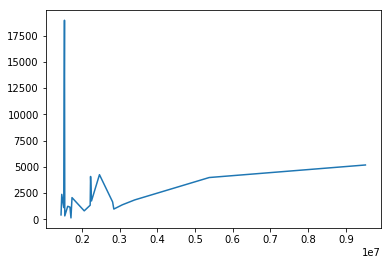

In [5]:
#Plot: Population on x axis, count of orders on y axis. There is an increase in order count
#with an increase in population. The large spike is for NYC which has abnormally high orders
#for its size. Only showing top 20 cities by population.

import matplotlib.pyplot as plt

plt.plot(df_ordersbycounty_pop['countypop'], df_ordersbycounty_pop['numoforders'])
plt.show() 

In [6]:
#Bad data: Null, non-numeric, or incorrectly long zipcodes in Orders table? 

#SELECT orderid, zipcode
#FROM orders
#WHERE zipcode IS NULL or 
#    (length(zipcode) != 5 and length(zipcode) != 7) or 
#    zipcode !~ '^([0-9]+[.]?[0-9]*|[.][0-9]+)$'
    
df_badzipcodes = pd.read_sql("SELECT orderid, zipcode FROM orders WHERE zipcode IS NULL or (length(zipcode) != 5 and length(zipcode) != 7) or zipcode !~ '^([0-9]+[.]?[0-9]*|[.][0-9]+)$'", con=conn)
df_badzipcodes.head()

,orderid,zipcode
0,1002444,0
1,1004051,M5R3R
2,1003454,
3,1003587,V6N2T
4,1003563,M5P3C


In [7]:
df_orders = pd.read_sql("SELECT orderid FROM orders", con=conn)
df_orders

print('Number of bad zipcodes: '+str(len(df_badzipcodes.index)))
print('Percent of bad zipcodes: '+str(len(df_badzipcodes.index)*100/len(df_orders.index)))

Number of bad zipcodes: 2548
Percent of bad zipcodes: 1.3203235518154448


In [8]:
#Zipcodes from Orders table not in zipcounty table?

#SELECT zipcode 
#FROM   orders o
#WHERE  NOT EXISTS (
#   SELECT 1           
#   FROM   zipcounty z
#   WHERE  o.zipcode = z.zipcode
#   );

df_nozipcounty = pd.read_sql("SELECT zipcode  FROM   orders o  WHERE  NOT EXISTS (SELECT 1  FROM   zipcounty z  WHERE  o.zipcode = z.zipcode)", con=conn)
df_nozipcounty.head()

,zipcode
0,0
1,M5R3R
2,
3,V6N2T
4,M5P3C


In [9]:
print('Number of order zipcodes not in zipcounty table: '+str(len(df_nozipcounty.index)))
print('Percent of order zipcodes not in zipcounty table: '+str(len(df_nozipcounty.index)*100/len(df_orders.index)))

Number of order zipcodes not in zipcounty table: 3950
Percent of order zipcodes not in zipcounty table: 2.0468124135286527


In [10]:
conn.close()